In [18]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import re
import ast
import scipy.stats as sp
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import BaggingRegressor
from sklearn import svm

# Reading feature set (without transformed features)
This dataframe excludes the transformed features (sqrt, inverse) which are present in the dataframe in the rbf_kernel notebook. 

In [51]:
df = pd.read_pickle("../data/feature_df.pkl")
display(df[0:3])

,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length,noun_count,adj_count,adv_count,verb_count,avg_word_freq,num_entities,num_people,avg_word_len,avg_word_sd,avg_word_skew,avg_word_kur
0,54,2019-10-14 23:45:05,"[Cara, Buckley, Tyler, Perry, hears, voices, i...",1332,[Cara Buckley Tyler Perry hears voices in his ...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...","{Cara: 'Cara', Buckley: 'Buckley', Tyler: 'Tyl...","Counter({'Perry': 23, 'said': 13, 'black': 12,...","{Cara: 'PROPN', Buckley: 'PROPN', Tyler: 'PROP...","{'LAW': ['the Ultimate Icon Award '], 'TIME': ...",3.687500,2.828125,1.625000,0.906250,1.003368,1.072613,0.772419,0.842893,2.894302,1.741689,1.327368,1.019162,0.850445,3.228395,0.824951,-0.446330,24.796875,0.801164,1.138566,14.053390,232,105,58,183,1.359667,72,20,4.493994,2.320905,0.984621,0.629332
1,18,2019-10-14 23:30:07,"[Robert, Leonard, Mr, Leonard, is, the, author...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",3.071429,1.628571,1.342857,0.914286,0.867576,1.056125,1.087943,1.193777,2.403629,1.456335,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753,208,89,61,118,1.448529,70,25,4.722414,2.655933,1.183618,1.660002
2,39,2019-10-14 23:15:04,"[Shuhan, Fan, and, Luther, Clement, Ms, Fan, a...",237,"[Shuhan Fan and Luther Clement, Ms Fan and Mr ...","['Shuhan', 'Fan', 'Luther', 'Clement', 'Ms', '...","{Shuhan: 'Shuhan', Fan: 'Fan', and: 'and', Lut...","Counter({'film': 6, 'Keeth': 5, 'Fan': 2, 'Lut...","{Shuhan: 'PROPN', Fan: 'PROPN', and: 'CCONJ', ...","{'ORG': ['Peter Westbrook Foundation ', 'the P...",3.333333,2.750000,1.166667,0.750000,0.252117,0.052602,1.009002,0.477594,2.839121,1.912875,1.337116,0.753778,-1.306829,-0.864689,0.204769,-0.868267,22.250000,-0.248484,-1.151573,11.250253,40,15,9,33,1.198020,14,7,4.624473,2.388066,0.949981,0.710818


In [52]:
### DEFINING HELPER FUNCTIONS

def get_name(df, entity, topic):
    '''
    Looks at each row of the df in the "named entities" column. If the entity is a key in the dict, it will
    look for the topic word in that list of entities, it will be in the outputted dataframe. 
    '''
    result = pd.DataFrame(columns = df.columns)
    data = []
    for i in range(len(df)):
        try:
            for j in range(len(df.named_entity[i][entity])):
                if df.named_entity[i][entity][j] == topic:
                    data.append(i)
        except:
            pass
    
    return df.iloc[data, :]

# Plotting function 
def plot(df, titles):
    '''
    Plots column in titles vs retweets for all items in "titles" list which should be a list of a 
    subset of the columns of df. 
    '''
    print("getting rid of " + str(len(df) - len(df.dropna(how='any',axis=0))) + " null columns")
    df = df.dropna(how='any',axis=0)

    X = df[titles].copy().values

    y = df[['retweets']].copy().values

    fig = plt.figure(figsize=(20, 50))
    for i in range(len(titles)):
        ax = fig.add_subplot(np.ceil(len(titles)/3), 3, i+1)
        ax.plot(X[:, i], y, 'o')
        ax.set_title(titles[i] + " vs retweets")
        
        
titles = ['word_count', 'avg_nouns_per_sentence',
       'avg_verbs_per_sentence', 'avg_adjs_per_sentence',
       'avg_advs_per_sentence', 'skew_nouns_per_sentence',
       'skew_verbs_per_sentence', 'skew_adjs_per_sentence',
       'skew_advs_per_sentence', 'sd_nouns_per_sentence',
       'sd_verbs_per_sentence', 'sd_adjs_per_sentence', 'sd_advs_per_sentence',
       'kurt_nouns_per_sentence', 'kurt_verbs_per_sentence',
       'kurt_adjs_per_sentence', 'kurt_advs_per_sentence',
       'avg_sentence_length', 'skew_sentence_length', 'kurt_sentence_length',
       'sd_sentence_length', 'noun_count', 'adj_count', 'adv_count',
       'verb_count', 'avg_word_freq', 'num_entities', 'num_people',
       'avg_word_len', 'avg_word_sd', 'avg_word_skew', 'avg_word_kur']

def get_xy_split(df):
    ''' Given a dataframe will split it into testing and training sets using scikit learn functionality.
    The titles in this function are the columns to be kept in the dataframe fed to the function. 
    
    '''
    df = df.dropna(how='any',axis=0)

    titles = ['word_count', 'avg_nouns_per_sentence',
           'avg_verbs_per_sentence', 'avg_adjs_per_sentence',
           'avg_advs_per_sentence', 'skew_nouns_per_sentence',
           'skew_verbs_per_sentence', 'skew_adjs_per_sentence',
           'skew_advs_per_sentence', 'sd_nouns_per_sentence',
           'sd_verbs_per_sentence', 'sd_adjs_per_sentence', 'sd_advs_per_sentence',
           'kurt_nouns_per_sentence', 'kurt_verbs_per_sentence',
           'kurt_adjs_per_sentence', 'kurt_advs_per_sentence',
           'avg_sentence_length', 'skew_sentence_length', 'kurt_sentence_length',
           'sd_sentence_length', 'noun_count', 'adj_count', 'adv_count',
           'verb_count', 'avg_word_freq', 'num_entities', 'num_people',
           'avg_word_len', 'avg_word_sd', 'avg_word_skew', 'avg_word_kur']

    X = df[titles].copy().values

    y = df[['retweets']].copy().values
    y = np.ravel(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

# run svr models on the testing set
def svr_tau(df, gamma, C, bag = False):
    ''' If given a dataframe, a gamma, and a C, will run a bagging regressor for SVR with the RBF kernel and 
    output the tau of the model FOR THE TEST SET. This function will be used in the complexity function below. 
    Inputs:
        df = dataframe containing features. It will be turned into a matrix according to get_xy_split.
        C, gamma = model complexity hyperparameters
    
    Outputs:
        tau = model metric
    
    '''
    from sklearn import svm
    from sklearn.ensemble import BaggingRegressor
    
    if bag: 
        X_train, X_test, y_train, y_test = get_xy_split(df)
        bag = BaggingRegressor(svm.SVR(kernel = 'rbf', gamma = gamma, C = C), max_samples=0.5, max_features=0.5)
        bag.fit(X_train, y_train)
        pred = bag.predict(X_test)
        tau, p_value = stats.kendalltau(pred, y_test)
        
    else: 
        X_train, X_test, y_train, y_test = get_xy_split(df)
        clf = svm.SVR(kernel='rbf', gamma = gamma, C = C)
        clf.fit(X_train, y_train) 
        pred = clf.predict(X_test)
        tau, p_value = stats.kendalltau(pred, y_test)
    
    return tau

# run svr models on the training set 
def svr_tau_train(df, gamma, C, bag = False):
    ''' If given a dataframe, a gamma, and a C, will run a bagging regressor for SVR with the RBF kernel and 
    output the tau of the model FOR THE TRAINING SET. This function will be used in the complexity function below. 
    Inputs:
        df = dataframe containing features. It will be turned into a matrix according to get_xy_split.
        C, gamma = model complexity hyperparameters
    
    Outputs:
        tau = model metric
    
    '''
    from sklearn.ensemble import BaggingRegressor
    from sklearn import svm
    
    if bag: 
        X_train, X_test, y_train, y_test = get_xy_split(df)
        bag = BaggingRegressor(svm.SVR(kernel = 'rbf', gamma = gamma, C = C), max_samples=0.5, max_features=0.5)
        bag.fit(X_train, y_train)
        pred = bag.predict(X_train)
        tau, p_value = stats.kendalltau(pred, y_train)
        
    else: 
        X_train, X_test, y_train, y_test = get_xy_split(df)
        clf = svm.SVR(kernel='rbf', gamma = gamma, C = C)
        clf.fit(X_train, y_train) 
        pred = clf.predict(X_train)
        tau, p_value = stats.kendalltau(pred, y_train)
    
    return tau

def optimize_hyperparameters(df, C_range, gamma_range):
    ''' If given a dataframe and a range of C's and gamma's will print the values of C and gamma which maximize
    tau. 
    Inputs:
        df = dataframe containing features. It will be turned into a matrix according to get_xy_split.
        C_range = range of C values
        gamma_range = range of gamma values
    
    Outputs:
        gamma = the gamma that outputted the highes tau 
    
    '''
    param_grid = dict(gamma=gamma_range, C=C_range)
    tau_dict = dict()
    
    for i in tqdm(range(len(C_range))):
        time.sleep(2)
        C = C_range[i]
        for j in range(len(gamma_range)):
            gamma = gamma_range[j]
            coord = (C, gamma)
            tau_dict[coord] = svr_tau(df, gamma, C)

    max_value = max(tau_dict.values())
    max_keys = [k for k, v in tau_dict.items() if v == max_value] # getting all keys containing the `maximum`
    print("Max tau: ", max_value, "(C, gamma): ", max_keys)
    
    return max_keys[0][1] # this is the gamma that results in the max tau

    
def get_complexity_plot(df, C_range, gamma, bag = False):
    ''' Given a dataframe, a range of C's and a fixed gamma, will plot the complexity vs tau plots, either
    just for SVR with RBF kernel or for both regular SVR and baggin SVR. 
    Inputs:
        df = dataframe containing features. It will be turned into a matrix according to get_xy_split.
        C_range = range of C values
        gamma = fixed gamma value
        bag = whether to use regular SVR or bagging SVR (both with rbf kernel)
    
    Outputs:
        One or two plots, according to whether bag = False or True. 
    
    '''
    if bag: 
        final_tau_bag = []
        final_tau_bag_train = []

    final_tau = []
    final_tau_train = []

    for i in tqdm(range(len(C_range))):
        time.sleep(2)
        C = C_range[i]
        final_tau.append(svr_tau(df, gamma, C, bag = False))
        final_tau_train.append(svr_tau_train(df, gamma, C, bag = False))
        if bag:
            final_tau_bag.append(svr_tau(df, gamma, C, bag = True))
            final_tau_bag_train.append(svr_tau_train(df, gamma, C, bag = True))

    if bag: 
        fig = plt.figure(figsize = (15, 5))
    else:
        fig = plt.figure()
        
    if bag: 
        ax = fig.add_subplot(1, 2, 1)
    else:
        ax = fig.add_subplot(1, 1, 1)
    ax.plot(C_range, final_tau, "-b", label = "Test Set")
    ax.plot(C_range, final_tau_train, "-r", label = "Train Set")
    ax.set_xlabel("C")
    ax.set_ylabel("Tau")
    ax.set_title("RBF SVR: Model Complexity vs Tau")
    plt.legend()

    if bag:
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(C_range, final_tau_bag, "-b", label = "Test Set")
        ax2.plot(C_range, final_tau_bag_train, "-r", label = "Train Set")
        ax2.set_xlabel("C")
        ax2.set_ylabel("Tau")
        ax2.set_title("Bagging RBF SVR: Model Complexity vs Tau")
        plt.legend()

    plt.show()

# Full Dataset

getting rid of 9 null columns


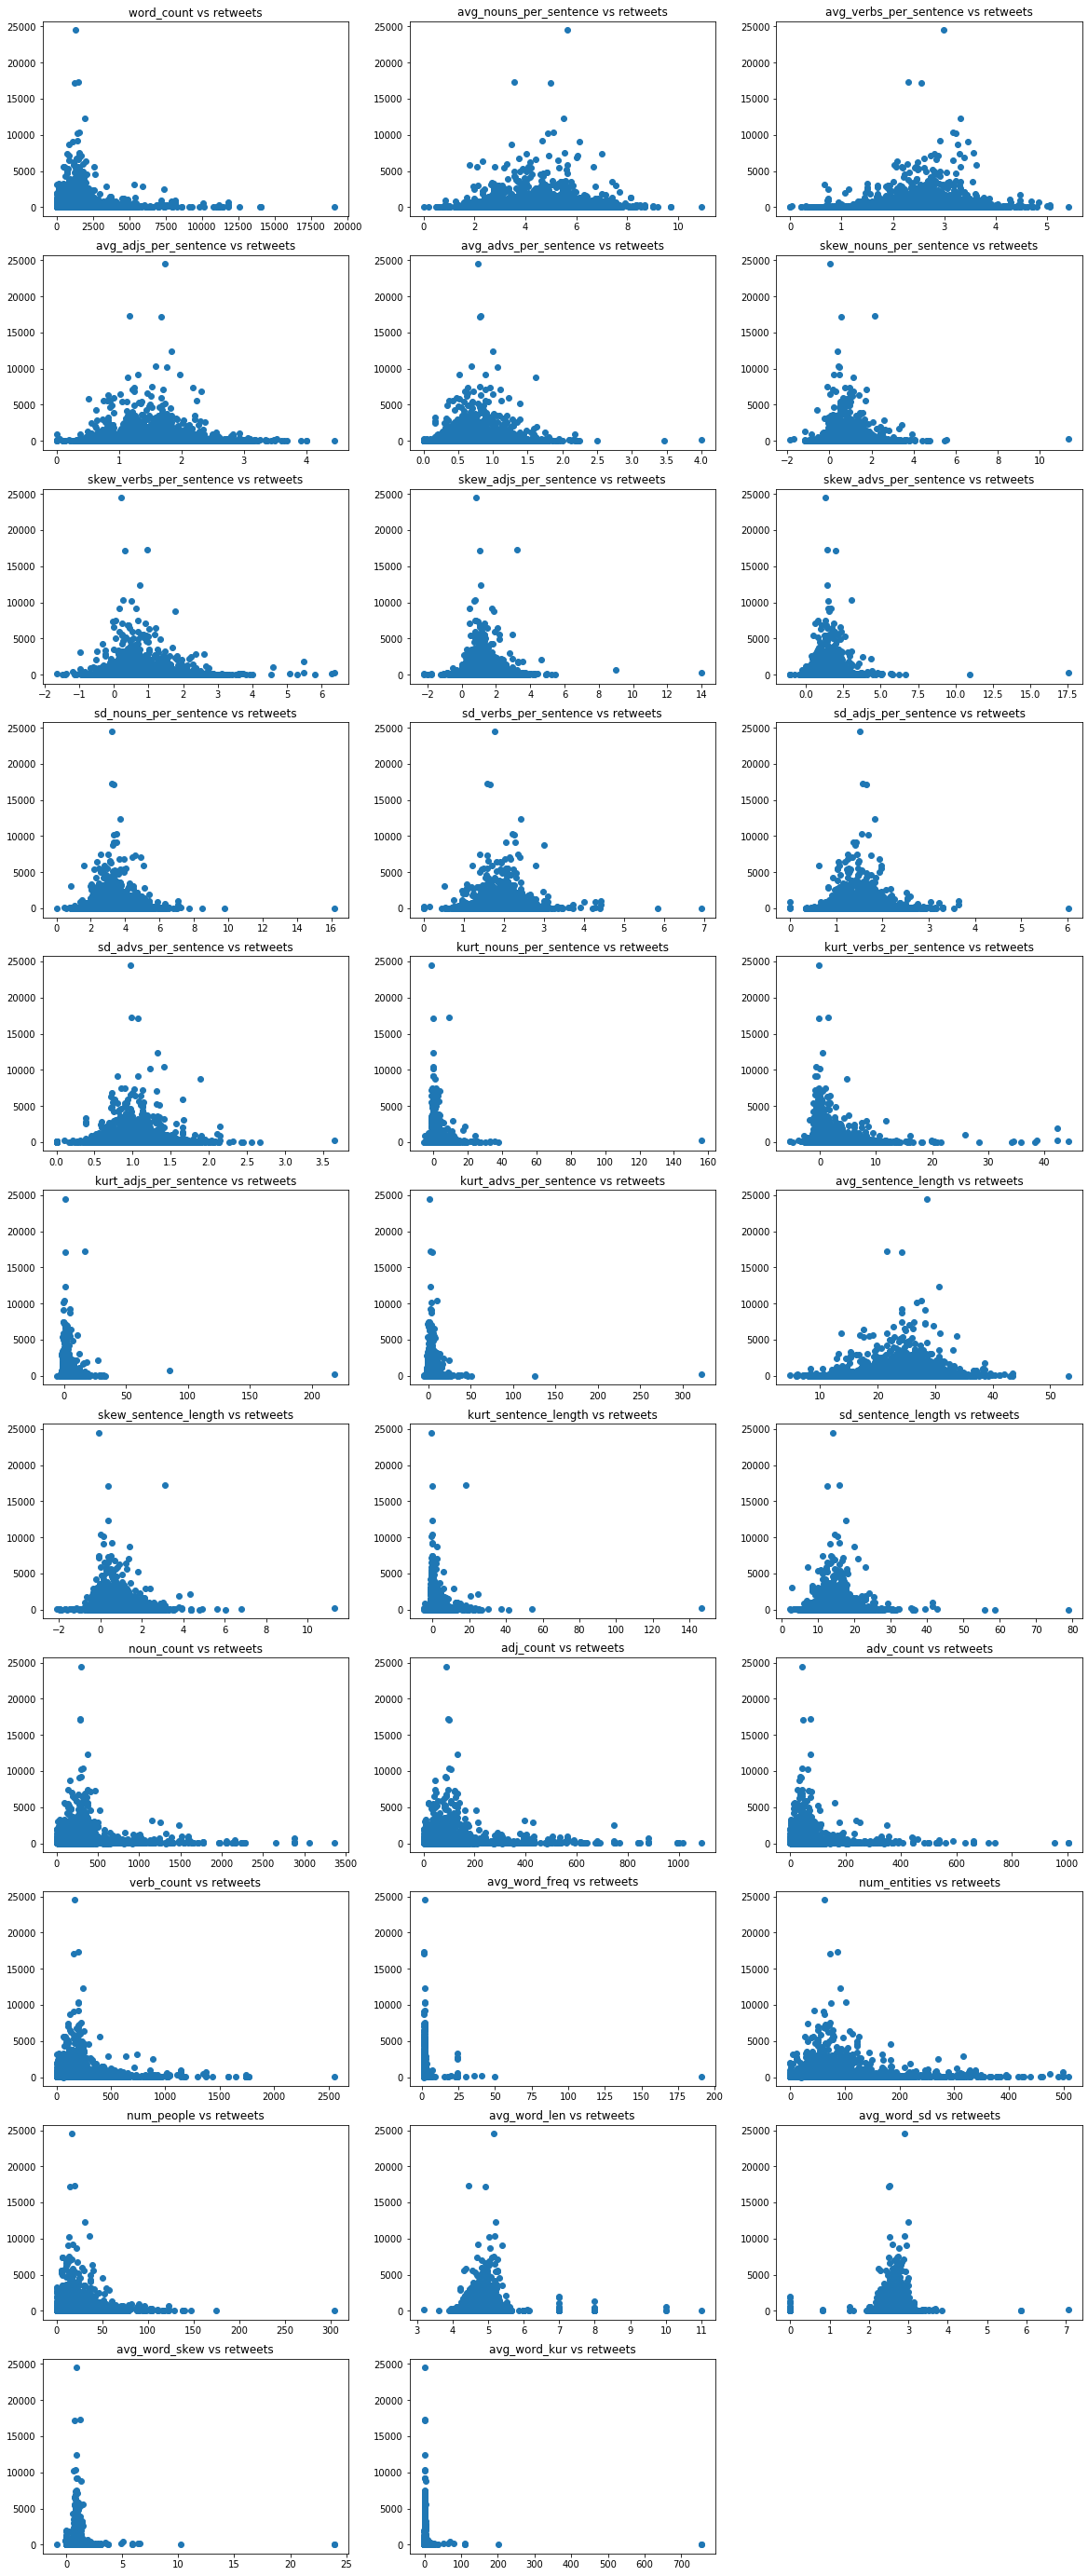

In [63]:
plot(df, titles)

In [ ]:
C_range = np.logspace(-5, 2, 15)
gamma_range = np.logspace(-5, 2, 15)

max_gamma = optimize_hyperparameters(df, C_range, gamma_range)
get_complexity_plot(df, C_range, max_gamma, bag = True)


Max tau:  0.25383909610254496 (C, gamma):  [(31.622776601683793, 1.0)]


# Exploring Trump Dataset

In [53]:
trump = get_name(df, 'PERSON', 'Trump ')
display(trump[0:3])

,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length,noun_count,adj_count,adv_count,verb_count,avg_word_freq,num_entities,num_people,avg_word_len,avg_word_sd,avg_word_skew,avg_word_kur
1,18,2019-10-14 23:30:07,"[Robert, Leonard, Mr, Leonard, is, the, author...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",3.071429,1.628571,1.342857,0.914286,0.867576,1.056125,1.087943,1.193777,2.403629,1.456335,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753,208,89,61,118,1.448529,70,25,4.722414,2.655933,1.183618,1.660002
9,147,2019-10-14 21:35:03,"[Patrick, Kingsley, The, Turkish, invasion, of...",1144,"[Patrick Kingsley, The Turkish invasion of Kur...","['Patrick', 'Kingsley', 'Turkish', 'invasion',...","{Patrick: 'Patrick', Kingsley: 'Kingsley', The...","Counter({'Syrian': 15, 'Turkey': 15, 'Kurdish'...","{Patrick: 'PROPN', Kingsley: 'PROPN', The: 'DE...","{'PRODUCT': ['Kurdishheld '], 'ORG': ['the Syr...",5.627907,2.813953,3.348837,1.116279,1.893373,1.070947,1.273637,0.859546,3.612302,1.880423,2.419009,1.028390,6.695291,1.429062,2.654446,0.308961,29.720930,1.497436,4.894056,13.973317,239,142,48,119,1.744737,63,6,5.076049,2.636879,0.706551,0.084566
14,181,2019-10-14 20:35:46,"[Sarah, Almukhtar, Allison, Mc, Cann, and, Anj...",2035,[Sarah Almukhtar Allison Mc Cann and Anjali Si...,"['Sarah', 'Almukhtar', 'Allison', 'Mc', 'Cann'...","{Sarah: 'Sarah', Almukhtar: 'Almukhtar', Allis...","Counter({'said': 30, 'Turkish': 20, 'Mr': 16, ...","{Sarah: 'PROPN', Almukhtar: 'PROPN', Allison: ...","{'TIME': ['Monday night ', 'Sunday night ', 'o...",4.636364,2.659091,2.147727,0.738636,0.084118,0.389915,0.487024,1.156936,2.812868,1.618047,1.778155,0.976674,-0.750457,0.460993,-0.599019,0.228333,26.886364,-0.005785,-0.121259,14.004459,397,188,64,235,1.771212,148,36,5.072727,2.544854,0.607579,0.062028


In [54]:
trump.shape

(3012, 41)

getting rid of 0 null columns


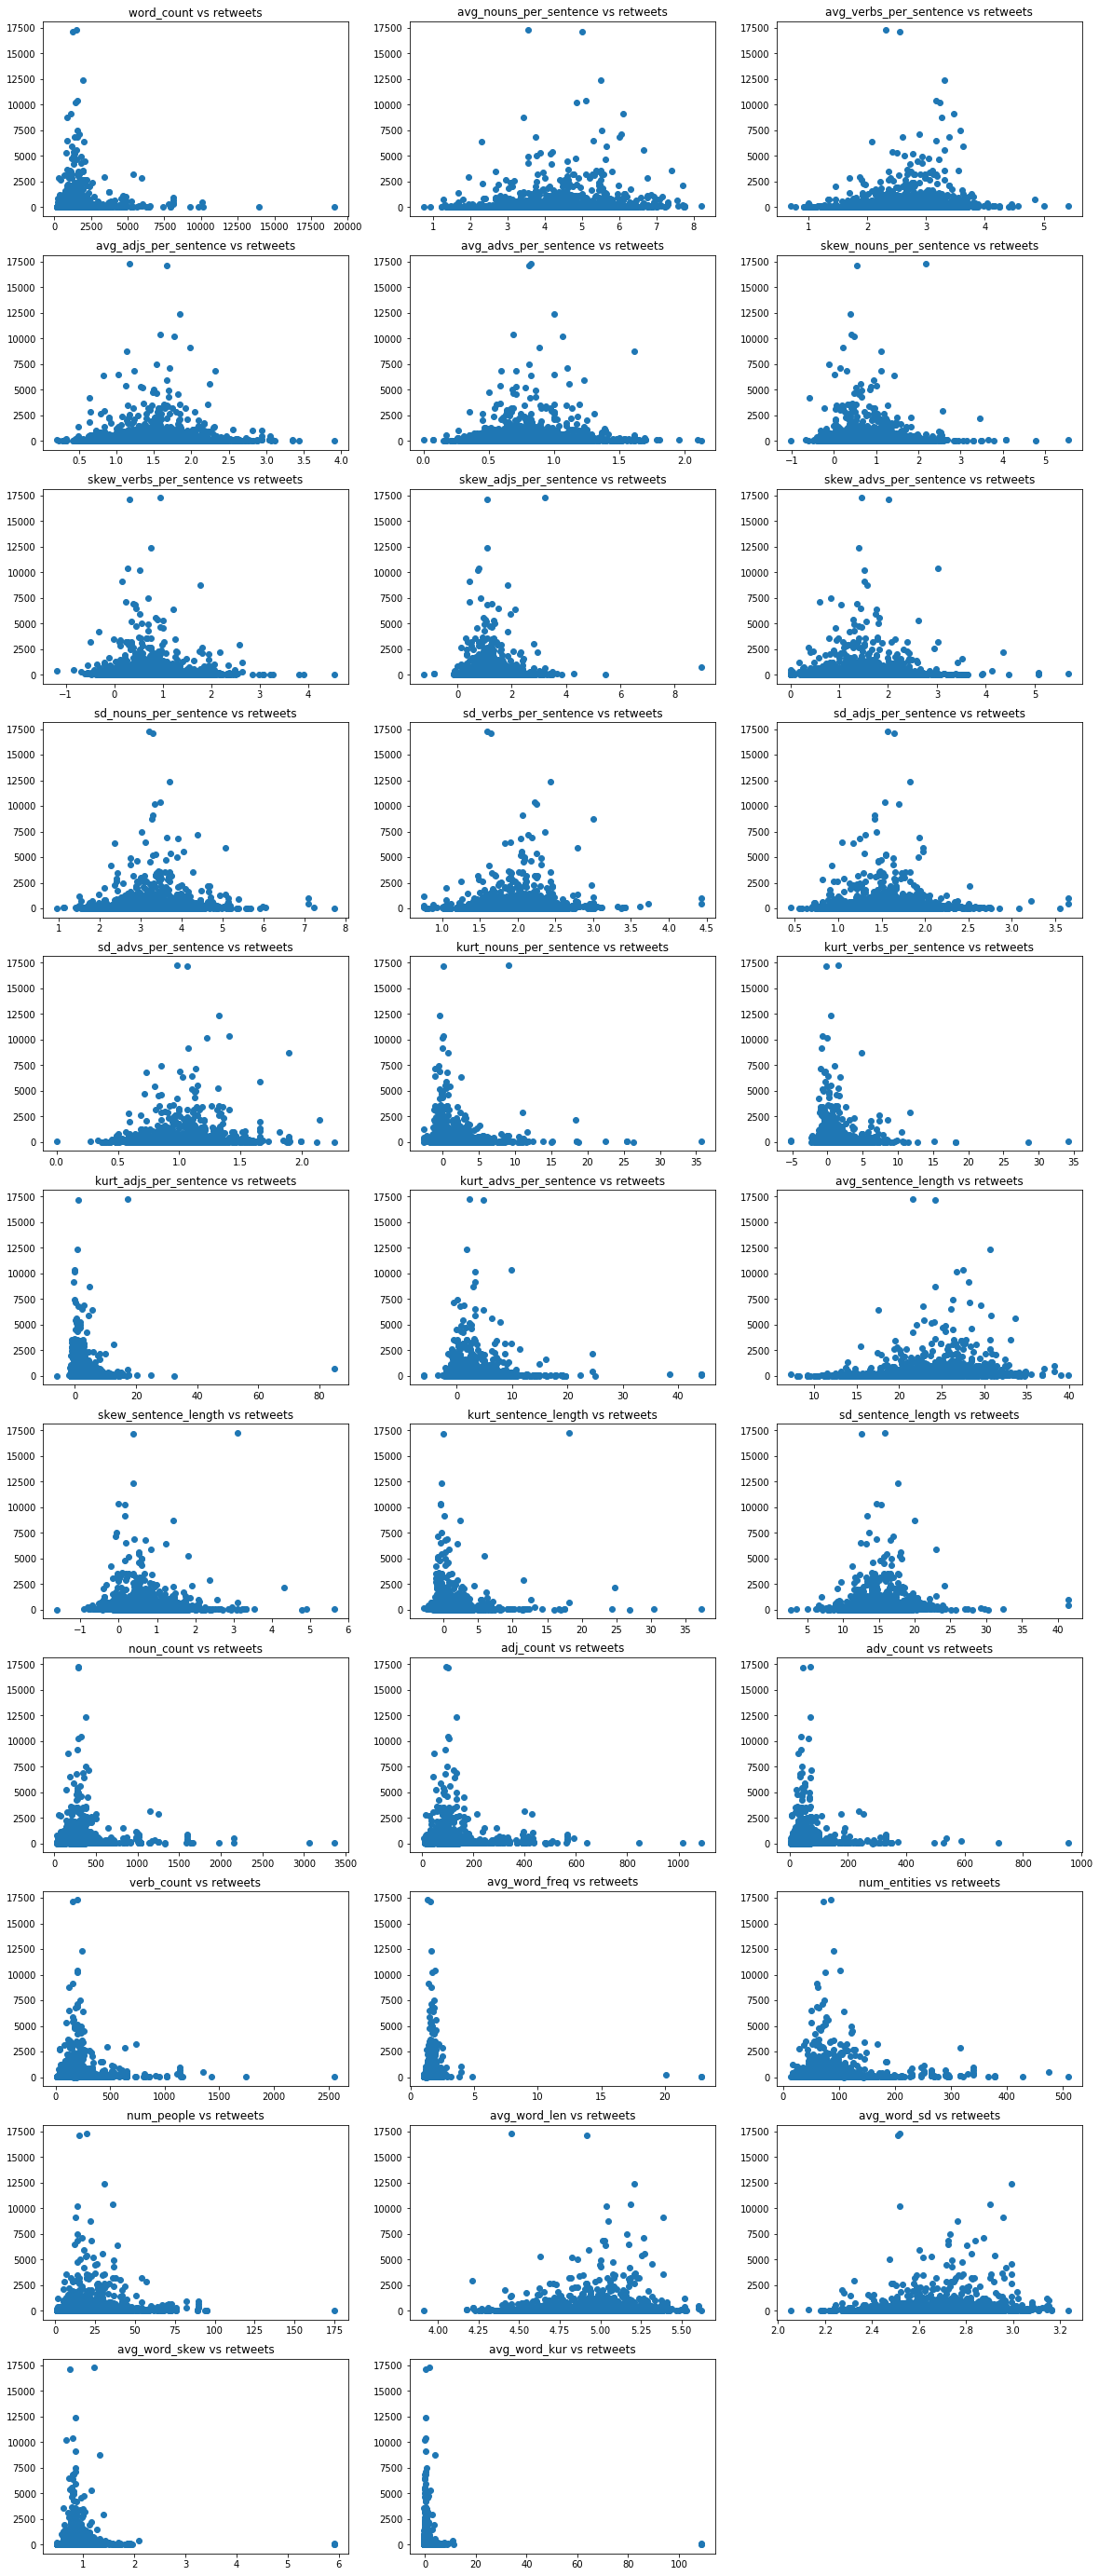

In [55]:
plot(trump, titles)


Max tau:  0.3108737615999186 (C, gamma):  [(100.0, 0.0001)]


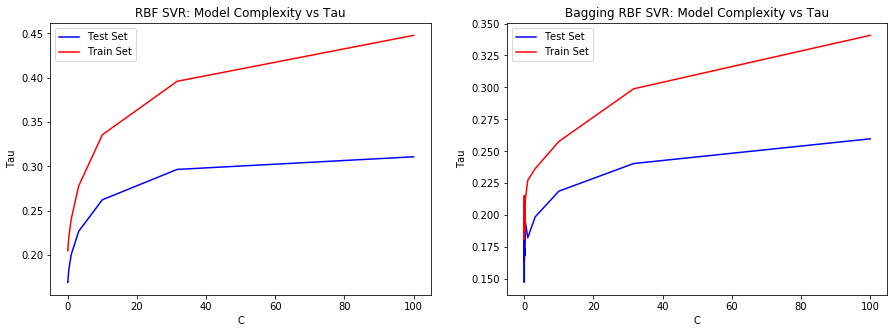

In [62]:
C_range = np.logspace(-5, 2, 15)
gamma_range = np.logspace(-5, 2, 15)

max_gamma = optimize_hyperparameters(trump, C_range, gamma_range)
get_complexity_plot(trump, C_range, max_gamma, bag = True)

# China Dataset

In [57]:
china = get_name(df, 'GPE', 'China ')
display(china[0:3])

,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length,noun_count,adj_count,adv_count,verb_count,avg_word_freq,num_entities,num_people,avg_word_len,avg_word_sd,avg_word_skew,avg_word_kur
26,33,2019-10-14 17:40:09,"[John, Branch, The, myth, of, sports, sticking...",1327,"[John Branch, The myth of sports sticking to s...","['John', 'Branch', 'myth', 'sports', 'sticking...","{John: 'John', Branch: 'Branch', The: 'the', m...","Counter({'sports': 22, 'China': 13, 'week': 8,...","{John: 'PROPN', Branch: 'PROPN', The: 'DET', m...","{'LAW': ['Game 7 '], 'TIME': ['midnight '], 'P...",4.105263,2.013158,1.171053,0.894737,0.593039,0.989717,1.657984,1.577839,3.031299,1.637017,1.408433,1.114498,-0.325094,1.542569,3.312157,3.157711,20.276316,0.760089,0.268387,12.974435,313,77,70,157,1.355899,81,19,4.855313,2.619016,0.961747,0.713965
30,47,2019-10-14 17:00:16,"[Matt, Phillips, Wall, Streets, eternally, opt...",783,[Matt Phillips Wall Streets eternally optimist...,"['Matt', 'Phillips', 'Wall', 'Streets', 'etern...","{Matt: 'Matt', Phillips: 'Phillips', Wall: 'Wa...","Counter({'companies': 7, 'profits': 7, 'growth...","{Matt: 'PROPN', Phillips: 'PROPN', Wall: 'PROP...","{'ORG': ['Bank of America ', 'Bank of America ...",4.428571,2.571429,1.666667,0.880952,0.846620,0.166435,0.416431,0.793655,3.061507,1.669568,1.182529,1.040694,0.754448,-0.752499,0.220036,-0.684665,21.523810,0.188754,-0.373143,11.184131,178,70,36,108,1.455516,49,5,4.939974,2.502152,0.821453,0.356846
35,56,2019-10-14 16:12:08,"[Michael, Forsythe, David, Enrich, and, Alexan...",3511,[Michael Forsythe David Enrich and Alexandra S...,"['Michael', 'Forsythe', 'David', 'Enrich', 'Al...","{Michael: 'Michael', Forsythe: 'Forsythe', Dav...","Counter({'Mr': 67, 'bank': 37, 'Deutsche': 36,...","{Michael: 'PROPN', Forsythe: 'PROPN', David: '...",{'LAW': ['the Foreign Corrupt Practices Act ']...,3.676617,1.950249,1.049751,0.557214,1.225079,1.204144,1.091973,1.544787,3.181179,1.728442,1.207275,0.811147,2.949429,1.772454,0.408060,2.210328,20.393035,1.013126,2.273361,13.255555,732,236,113,415,2.201064,210,64,4.918257,2.645673,0.784474,-0.008584


In [58]:
china.shape

(1493, 41)

getting rid of 0 null columns


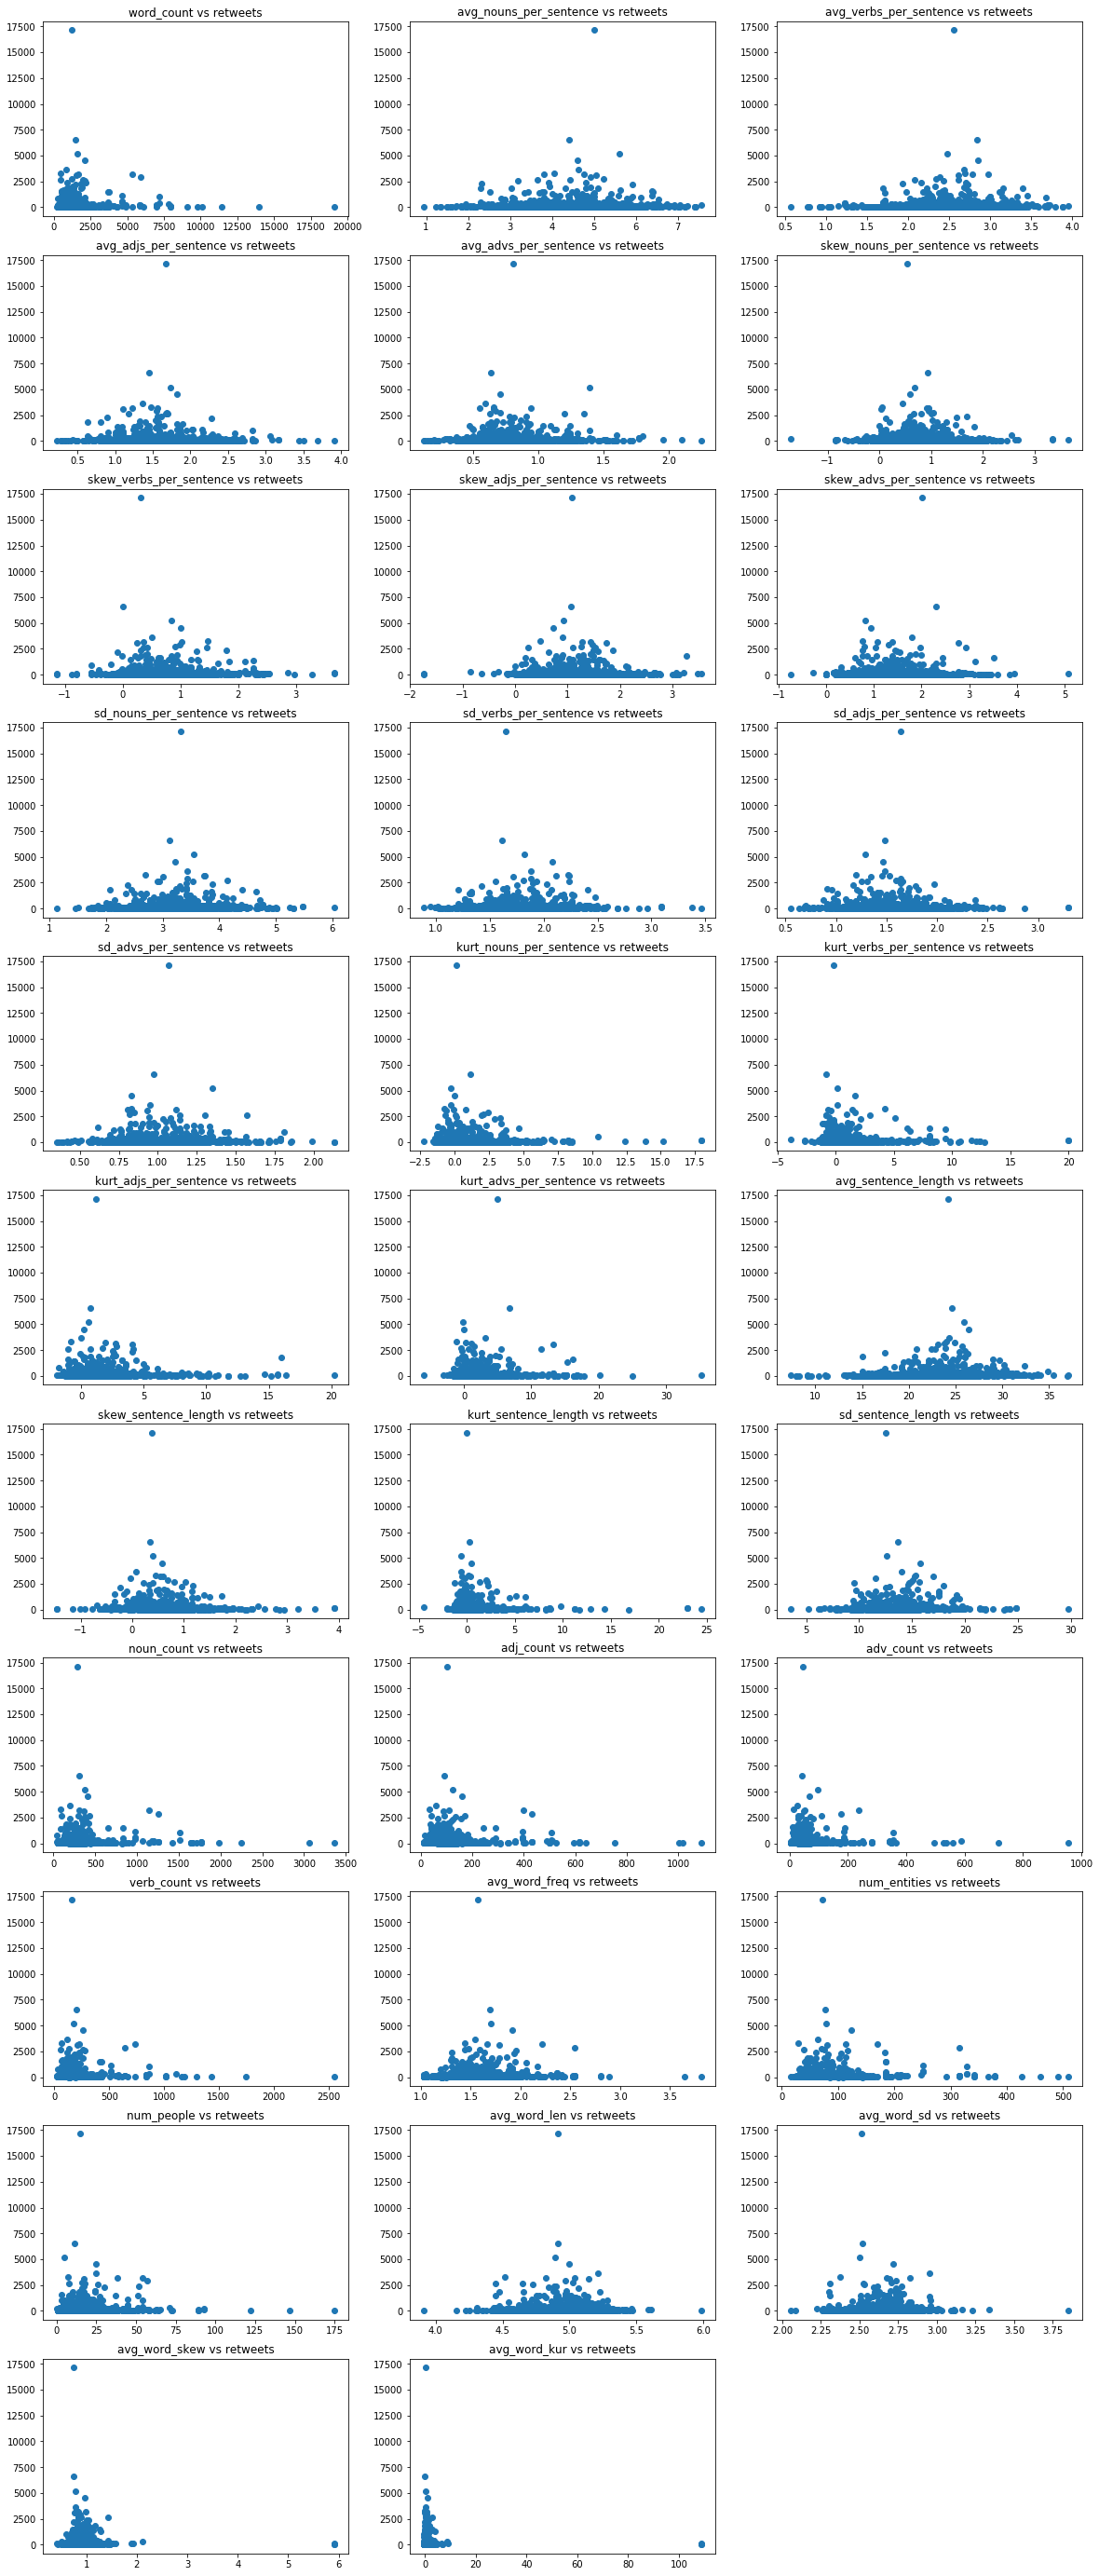

In [59]:
plot(china, titles)

In [ ]:
C_range = np.logspace(-3, 3, 15)
gamma_range = np.logspace(-3, 3, 15)

max_gamma = optimize_hyperparameters(china, C_range, gamma_range)
get_complexity_plot(china, C_range, max_gamma, bag = True)